# Redes Neuronales Artificiales
## Trabajo Practico 1

###Diagnóstico de cáncer de mamas.
*Este conjunto de datos contiene los resultados de un examen específico que es utilizado en el diagnóstico de cáncer de mamas. Cada entrada corresponde a los datos obtenidos para distintos pacientes y contiene 10 características provenientes de imágenes digitalizadas de muestras de células. Junto con estas
características se encuentra también el diagnóstico final, determinado gracias también a otras pruebas, en donde se indica si la muestra analizada pertenecía a un tumor maligno o benigno. El conjunto de datos tiene como primera columna el Diagnóstico (1=maligno, 0=benigno), y la información en valores reales de los atributos Radio (media de la distancia desde el centro a los puntos de perímetro), Textura (desviación estándar de los valores en escala de gris), Perímetro, Área, Suavidad (variaciones locales en la longitud del radio), Compacidad (perímetro2 / área - 1), Concavidad (severidad de las porciones cóncavas del contorno), Puntos cóncavos (proporción de porciones cóncavas del contorno), Simetría y Dimensión fractal. Deberá determinarse si es posible utilizar un modelo de red neuronal artificial para predecir el diagnóstico final utilizando únicamente los datos de este examen.*

**Para este trabajo implementamos una clase que instancia una red neuronal al que se le puede definir número de capas, neuronas por capa y funciones de activación para cada capa.
Se probaron diferentes arquitecturas desde las más simples a más complejas.**

In [ ]:
#Imports
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class MLP:
    def __init__(self, sizes, Xdim, func_list):
        """
        sizes = list of amount of neurons per layer
        Xdim = tuple of X dimensions
        func_list = list of function with len == len(size)
        """
        self.Xdim = Xdim
        self.S = sizes
        self.L = len(self.S)
        self.Y = [] #lista de valores predichos en cada época
        #Inicialización de pesos utilizando una distribución normal, centrada en 0 con desvío 0,01
        self.W = [np.random.normal(0, 0.01, (Xdim[1]+1, self.S[0]))] + [np.random.normal(0, 0.01, (self.S[i-1]+1,self.S[i])) for i in range(1, self.L)]
        self.dW = [np.zeros(i.shape) for i in self.W] #Inicialización de matrices de correción de pesos
        self.total_error = [] #Error calculado (MSE) en cada época

        # Lista de funciones de activación y sus correspondientes derivadas (para backpropagation) para cada capa
        #len(self.act_funcs) == len(sizes)
        self.act_funcs = []
        self.back_dev_funcs = []

        for func in func_list:
            #func se corresponde a un nombre(str) correpondiente a una función de activación
            if func == "tanh":
                act_func = np.tanh
                back_dev_func = lambda x: 1 - np.square(x)
            elif func == "logit":
                act_func = lambda x: 1 / (1 + np.exp(-x))
                back_dev_func = lambda x: x*(1-x)
            elif func == "ReLu":
                act_func = lambda x: np.maximum(0, x)
                back_dev_func = lambda x: np.where(x > 0, 1, 0)
            elif func == "lin":
                act_func = lambda x: x
                back_dev_func = lambda x: 1

            self.act_funcs.append(act_func)
            self.back_dev_funcs.append(back_dev_func)



        # print(f"Size: {self.L}")
        # print(f"Pesos: {[i.shape for i in self.W]}")

    def bias_add(self,V):
        bias = np.ones((V.shape[0],1))
        return np.hstack([V,bias])

    def bias_sub(self, V):
        return V[:,:-1]

    def activacion(self, X):
        Y = []
        Y0 = X
        for k in range(self.L):
            Y.append(self.bias_add(Y0))
            Y0 = self.act_funcs[k](np.dot(Y[k], self.W[k]))
        Y.append(Y0)
        return Y

    def correction(self, Y, Z):
        E = Z - Y[-1]
        dY = self.back_dev_funcs[-1](Y[-1])
        D = E * dY
        for k in reversed(range(self.L-1)):
            self.dW[k+1] = np.dot(Y[k+1].T, D)
            E = np.dot(D, self.W[k+1].T)
            dY = self.back_dev_funcs[k](Y[k+1])
            D = self.bias_sub(E * dY)
        self.dW[0] = np.dot(Y[0].T, D)

    def adaptacion(self, lr, beta):
        for k in range(self.L):
            if k not in self.velocity:
                self.velocity[k] = np.zeros_like(self.W[k])

            self.velocity[k] = beta * self.velocity[k] + (1-beta) * self.dW[k]
            self.W[k] = self.W[k] + (lr * self.velocity[k])

    def MSE(self, Z, Y):
        """
        Calcula el MSE entre los valores predichos(Y) y los verdaderos(Z)
        """
        return np.mean(np.square(Z - Y[-1]))

    def estimation(self, Z, Y):
        self.total_error.append(self.MSE(Z,Y))
        return self.total_error[-1]

    def train(self, X, Z, error = 0.01, lr = 0.001 , batch_size = True, epochs = 1000, beta = 0, verbose = True, validation = False):
        """
        Entrenamiento de la red neuronal.
        batch_size = tamaño de lote de entrenamiento
        """
        self.history_pred = {"train_list":[] , "val_list":[]} #Acumula valores predichos en cada época, para conjuntos de train o de validación.
        if validation:
            self.validation_error = []
        self.velocity = {} #Matriz de velocidades, si se utiliza incercia (beta != 0)

        current_epoch = 0
        E = error+1 #Inicialización del error

        while E > error:
            stochastic = np.random.permutation(self.Xdim[0])
            # Y = self.predict(X)
            for h in range(0 , self.Xdim[0] , batch_size):       #la diferencia radica aca, lo vamos a generalizar para dado un h, sumarle B filas
                if(min(h+batch_size , self.Xdim[0]) == h+batch_size):
                    batch = stochastic[ h:h+batch_size ]
                if(min(h+batch_size ,self.Xdim[0]) == self.Xdim[0]):
                    batch = stochastic[h:]

                Y0h = X[batch,:]
                Zh = Z[batch,:]

                Yh = self.activacion(Y0h)
                self.correction(Yh,Zh)
                self.adaptacion(lr, beta)

                E = self.estimation(Zh,Yh)

                if validation:
                    self.validation_error.append(self.MSE(validation[1], self.predict(validation[0])))
                    self.history_pred["val_list"].append(self.predict(validation[0]) )

                self.history_pred["train_list"].append(self.predict(X) )

            if verbose:
                if current_epoch % 1000 == 0:
                    print(f"Epoch: {current_epoch}, Error -> {E}")
            current_epoch+=1

            if current_epoch > epochs:
                break

    def predict(self, X):
        Y = []
        Y0 = X
        for k in range(self.L):
            Y.append(self.bias_add(Y0))
            Y0 = self.act_funcs[k](np.dot(Y[k], self.W[k]))
        Y.append(Y0)
        return Y[-1]

In [ ]:
def calcular_metricas(X,Z,modelo):
    """
    Calculates metrics using a threshold of 0.5
    """

    y_predict = modelo.predict(X)
    y_pred_class = np.where(y_predict >= 0.5, 1, 0)

    true_positives = np.sum((y_pred_class == 1) & (Z == 1))
    true_negatives = np.sum((y_pred_class == 0) & (Z == 0))
    false_positives = np.sum((y_pred_class == 1) & (Z == 0))
    false_negatives = np.sum((y_pred_class == 0) & (Z == 1))

    accuracy = (true_positives + true_negatives) / len(Z)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return accuracy, precision, recall

def cross_val(X ,Z, sizes, func_list, NSets = 5, error = 0.01, lr = 0.001 , batch_size = True, epochs = 1000, beta = 0, verbose = True):
    '''
    X es el dataset de entrada , NSets es el numero de sets que deseo generar para la validacion cruzada

    devuelve una tupla que contiene la lista de train_sets , y la lista de val_sets que se corresponden en orden
    '''

    lista_indices = []
    for indice in range(0, X.shape[0] , int(np.floor(X.shape[0]/NSets))):

        if(min(indice+np.floor(X.shape[0]/NSets) , X.shape[0])==(indice+np.floor(X.shape[0]/NSets))):

            lista_indices.append((indice, (indice+np.floor(X.shape[0]/NSets))))#aca estoy en duda si hace o no falta el -1

        elif(min(indice+np.floor(X.shape[0]/NSets) , X.shape[0])==X.shape[0]):#quiero que sea inclusivo esto, y que no quede fuera de rang

            lista_indices.append((indice, X.shape[0]))

    #ahora la idea es usar esta lista de indices, para recorta a X entre train y validation

    lista_train_sets = []
    lista_train_Z_sets = []
    lista_val_sets = []
    lista_val_Z_sets = []

    for i in range(0 , len(lista_indices)):

        #X = np.random.permutation(X.shape[0])#creo que esto vale la pena, para agregar variabilidad al crossval

        lista_train_sets.append(np.vstack((X[:int(lista_indices[i][0]) , :] , X[int(lista_indices[i][1]): , :])))
        lista_train_Z_sets.append(np.vstack((Z[:int(lista_indices[i][0]) , :] , Z[int(lista_indices[i][1]): , :])))
        #vstack recibe una tupla de lo que quiero apilar, o sea np.vstack((a,b))
        lista_val_sets.append(X[int(lista_indices[i][0]):int(lista_indices[i][1]) , :])
        lista_val_Z_sets.append(Z[int(lista_indices[i][0]):int(lista_indices[i][1]) , :])

    redes = {}
    train_errors = []
    validation_errors = []
    metrics = {"accuracy": [], "precision":[],"recall":[]}
    i=0
    for X_train, X_val, Z_train, Z_val in zip(lista_train_sets , lista_val_sets, lista_train_Z_sets, lista_val_Z_sets):
        Xdim = X_train.shape
        redes[i] = MLP(sizes, Xdim, func_list)
        redes[i].train(X_train , Z_train , error = error , lr = lr , batch_size = batch_size, epochs = epochs, validation = (X_val, Z_val), beta = beta, verbose = verbose)
        train_errors.append(redes[i].total_error)
        validation_errors.append(redes[i].validation_error)
        #Metricas
        accuracy, precision, recall = calcular_metricas(X, Z, redes[i])
        metrics["accuracy"].append(accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)

        i+=1

    return redes, train_errors, validation_errors, metrics

# def crossval_metrics(model_dic, X, Z):
#     metrics = {"accuracy": [], "precision":[],"recall":[]}
#     for model in model_dic:
#         accuracy, precision, recall = calcular_metricas(X,Z,modelo)
#         metrics["accuracy"].append(accuracy)
#         metrics["precision"].append(precision)
#         metrics["recall"].append(recall)
#     return { key: sum(values) / len(values) for key, values in metrics.items() }

In [ ]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv')

data = np.loadtxt(r.iter_lines() , delimiter = ', ')


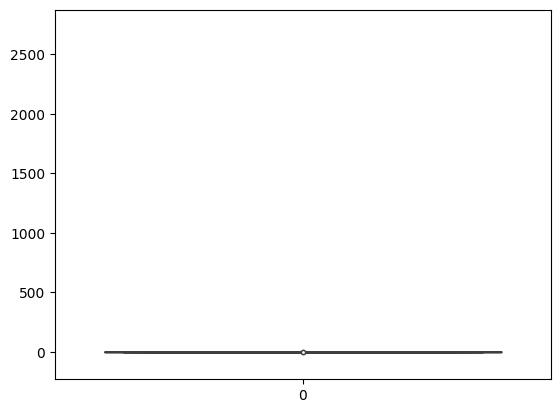

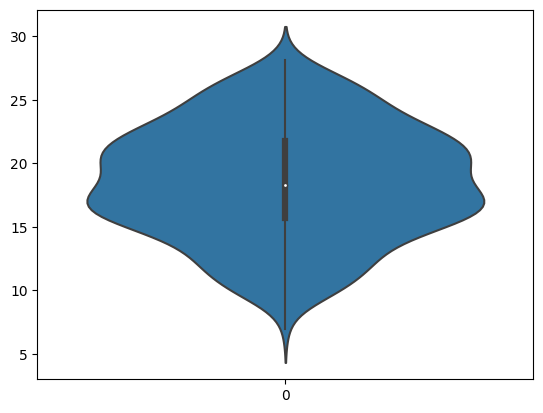

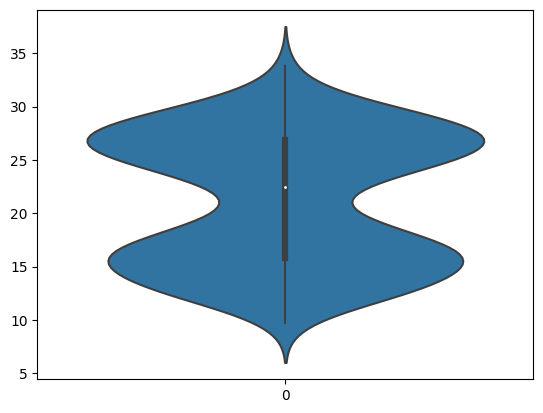

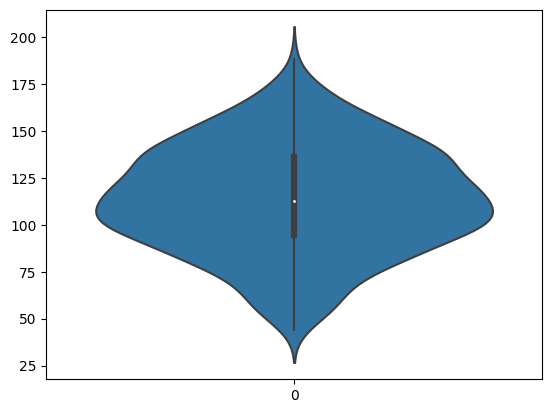

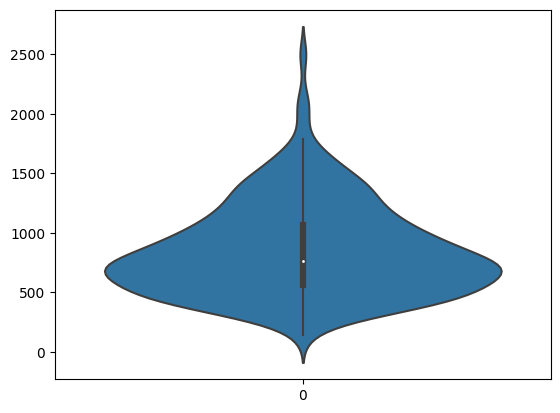

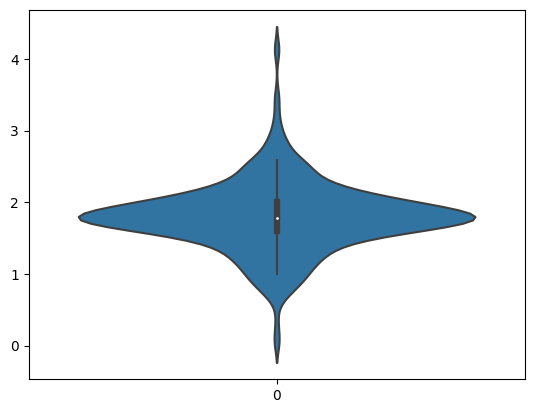

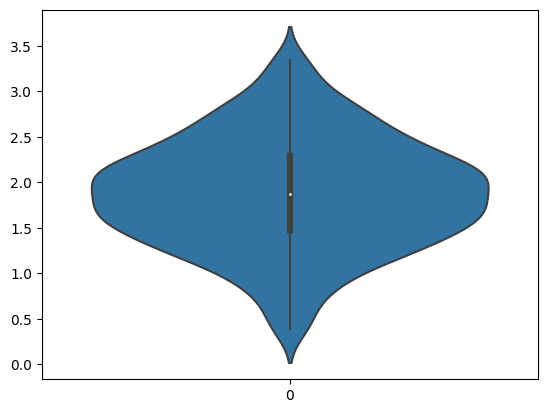

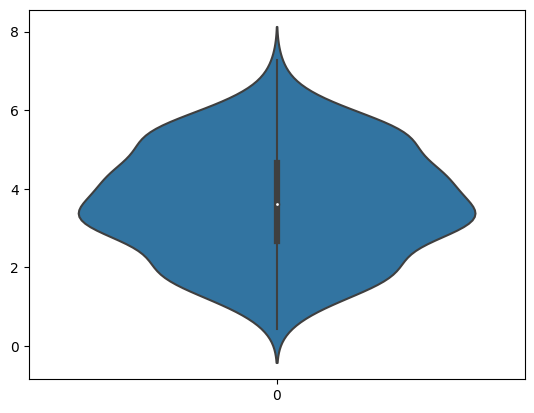

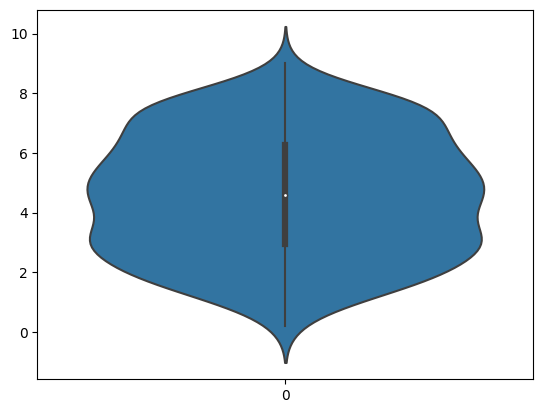

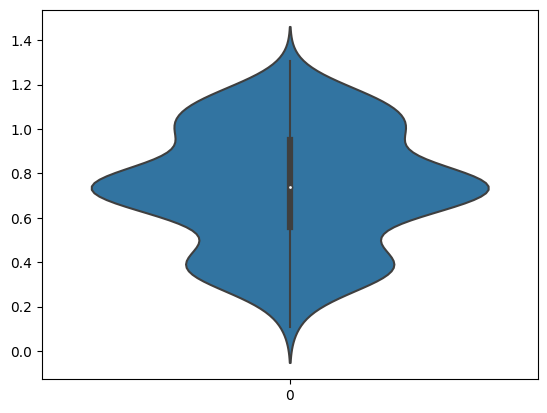

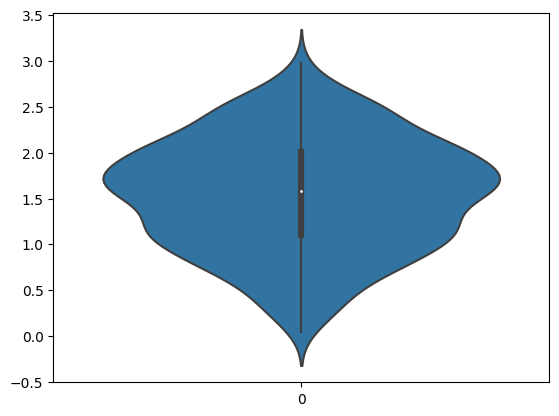

variable0   Q25: 0.0 Q50: 0.0 Q75: 1.0 media: 0.47560975609756095 std: 0.49940476169373826
variable1   Q25: 15.6605 Q50: 18.299999999999997 Q75: 21.7805 media: 18.529660975609755 std: 4.44048133621318
variable2   Q25: 15.794 Q50: 22.448 Q75: 26.914 media: 21.283626829268293 std: 6.1568716014580955
variable3   Q25: 94.51374999999999 Q50: 112.7465 Q75: 136.11575 media: 113.75520487804877 std: 28.568607823409618
variable4   Q25: 557.17475 Q50: 765.2394999999999 Q75: 1064.4914999999999 media: 851.3470585365853 std: 388.6463056424672
variable5   Q25: 1.5942500000000002 Q50: 1.785 Q75: 2.00275 media: 1.7958585365853659 std: 0.4811055150104478
variable6   Q25: 1.473 Q50: 1.8715000000000002 Q75: 2.28725 media: 1.8802975609756098 std: 0.6086355265184514
variable7   Q25: 2.67925 Q50: 3.6189999999999998 Q75: 4.6665 media: 3.6691487804878054 std: 1.407744618888919
variable8   Q25: 2.935 Q50: 4.5745000000000005 Q75: 6.2655 media: 4.572424390243902 std: 2.037665547460514
variable9   Q25: 0.559750000

In [ ]:
#analisis exploratorio de datos, para chequear temita de dispercion de datos, si hace falta transformarlos
#y sobre todo si hay outliers, o algo a tener en cuenta, claramente los graficos al informe no, xq no libraries!=np|plt|requests

sns.violinplot(data = data)

#para graficar cada violiin por separado

for columna in range(0 , data.shape[1]):

    sns.violinplot(data[:,columna])

    plt.show()

    plt.close()
#para ver la estadistica descriptiva de cada var por separado

for columna in range(0 , data.shape[1]):

    print(f'variable{columna}   Q25: {np.quantile(data[:,columna] , 0.25)} Q50: {np.quantile(data[:,columna] , 0.5)} Q75: {np.quantile(data[:,columna] , 0.75)} media: {np.mean(data[:,columna])} std: {np.std(data[:,columna])}')

Definimos las columnas de *features* y la columna de *labels*.

In [ ]:
#generamos el dataset de input y target como X y Z

Z = data[:,0].reshape(410 , -1)

X = data[: , 1:]

print(X.shape , Z.shape)

(410, 10) (410, 1)


Probamos 3 normalizaciones diferentes. Terminamos decantándonos por la que divide cada *feature* por su propio desvio estandar: `normalized_X`. (Todas estas pruebas no se muestran en este notebook).

In [ ]:
#normalizacion pesada por el desvio estandar total
mean = np.mean(X, axis=0)
std = np.std(X)
normalized_X_tot = (X - mean) / std
#Total variance
normalized_X_tot_var = (X - mean) / np.square(std)
#normalizacion pesada por el desvio estandar de cada variable
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
normalized_X = (X - mean) / std


Para las pruebas generamos aleatoriamente un conjunto de entrenamiento y un conjunto de validación.

In [ ]:
# Set the random seed for reproducibility (optional)
np.random.seed(42)

# Create an array of shuffled indexes
shuffled_indexes = np.random.permutation(len(normalized_X))

# Define the percentage split between train and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate the number of samples for the training set
train_samples = int(train_ratio * len(normalized_X))

# Split the indexes into training and validation sets
train_indexes = shuffled_indexes[:train_samples]
val_indexes = shuffled_indexes[train_samples:]

# Create the training and validation sets
X_train, z_train = normalized_X[train_indexes], Z[train_indexes]
X_val, z_val = normalized_X[val_indexes], Z[val_indexes]

## Entrenamiento de REDES
Para este problema decidimos utilizar una función de salida Sigmoidea dada la naturaleza binaria de los labels. En las capas ocultas utilizamos la funcion tangente hiperbólica dado que esta centrada en cero (al igual que los datos normalizados), porque puede tomar valores positivos o negativos, es derivable y no lineal.

### Primero probamos las diferencias entre los distintos tamaños de batches
Más que nada para ver si el algoritmo de batches estaba bien implementado y para ver que tanto afectaba las métricas y el error.

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained


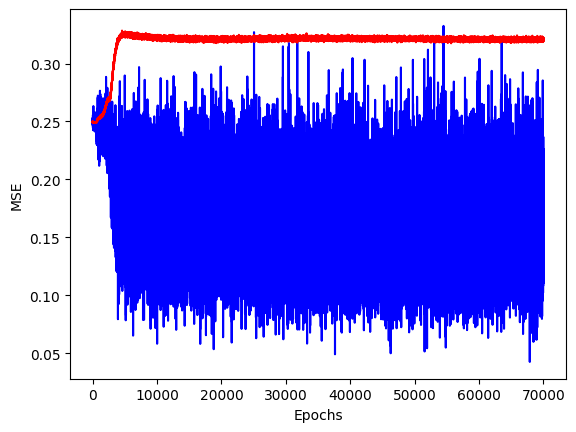

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained


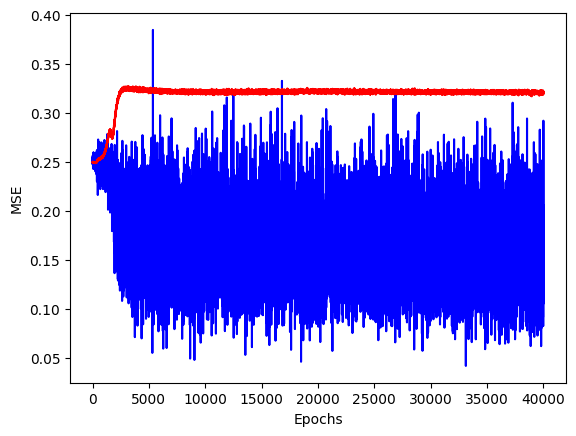

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained


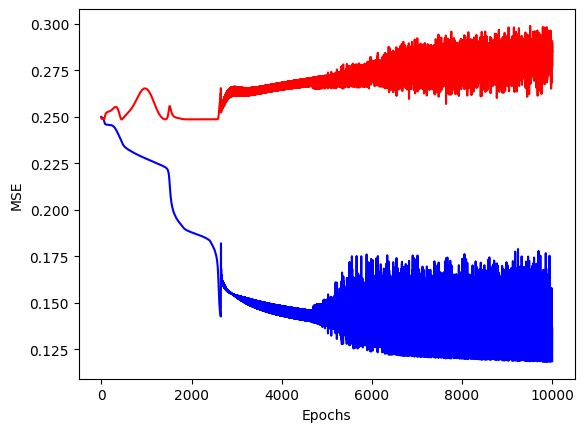

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Promedio de métricas para el modelo de batch=50: 
{'accuracy': 0.7324390243902439, 'precision': 0.8457970506187344, 'recall': 0.52}
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Promedio de métricas para el modelo de batch=100

In [ ]:
#Test de batches
modelo_batch_1 = MLP( [2,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_1.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_1.total_error, color='blue', label='train')
plt.plot(modelo_batch_1.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
###
modelo_batch_2 = MLP( [2,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_2.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 100, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_2.total_error, color='blue', label='train')
plt.plot(modelo_batch_2.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
###
modelo_batch_3 = MLP( [2,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_3.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 500, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_3.total_error, color='blue', label='train')
plt.plot(modelo_batch_3.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()

#Crossval
_, _, _, metrics = cross_val(normalized_X ,Z, [2,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 10000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de batch=50: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })
_, _, _, metrics = cross_val(normalized_X ,Z, [2,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 100, epochs = 10000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de batch=100: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })
_, _, _, metrics = cross_val(normalized_X ,Z, [2,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 500, epochs = 10000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de batch=Total: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

#### Testeo de Arquitecturas

Utilizamos arquitecturas de 1 o 2 capas ocultas con "pocas" o "muchas" neuronas.

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained


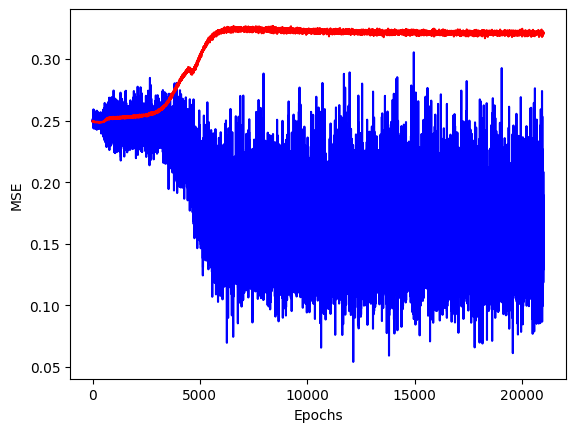

Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Size: 2
Pesos: [(11, 2), (3, 1)]
Trained
Promedio de métricas para el modelo de 1 HL con 2 neuronas: 
{'accuracy': 0.7475609756097561, 'precision': 0.8274089077872688, 'recall': 0.5948717948717949}
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained


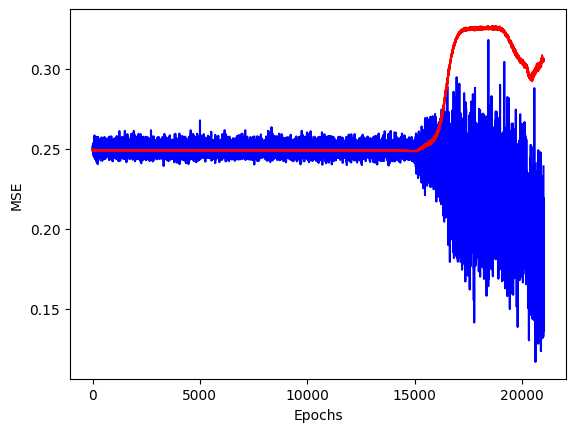

Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]


<ipython-input-34-4f19f0389ebf>:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positives / (true_positives + false_positives)


Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Size: 3
Pesos: [(11, 1), (2, 2), (3, 1)]
Trained
Promedio de métricas para el modelo de 2 HL con [1, 2] neuronas: 
{'accuracy': 0.5597560975609757, 'precision': nan, 'recall': 0.23179487179487177}
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained


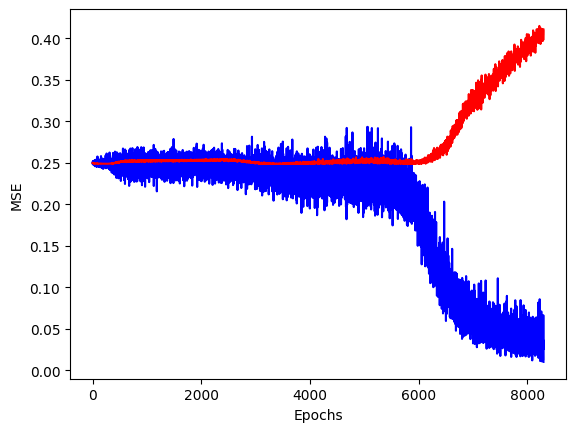

Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Promedio de métricas para el modelo de 1 HL con 12 neuronas: 
{'accuracy': 0.9407317073170731, 'precision': 0.950023157668603, 'recall': 0.9241025641025642}
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained


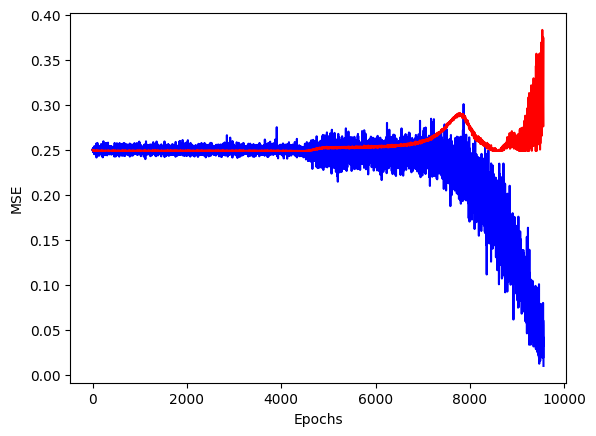

Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Size: 3
Pesos: [(11, 10), (11, 20), (21, 1)]
Trained
Promedio de métricas para el modelo de 2 HL con [1, 2] neuronas: 
{'accuracy': 0.9090243902439024, 'precision': 0.9296083471590817, 'recall': 0.874871794871795}


In [ ]:
#Modelos
modelo_norm_1HL_1 = MLP( [2,1] , X_train.shape, ["tanh",'logit'])

modelo_norm_1HL_1.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 3000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_norm_1HL_1.total_error, color='blue', label='train')
plt.plot(modelo_norm_1HL_1.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
_, _, _, metrics = cross_val(normalized_X ,Z, [2,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de 1 HL con 2 neuronas: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

###

modelo_norm_2HL_1 = MLP( [1,2,1] , X_train.shape, ["tanh","tanh",'logit'])

modelo_norm_2HL_1.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 3000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_norm_2HL_1.total_error, color='blue', label='train')
plt.plot(modelo_norm_2HL_1.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
_, _, _, metrics = cross_val(normalized_X ,Z, [1,2,1], ["tanh","tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de 2 HL con [1, 2] neuronas: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

###
#Más neuronas
modelo_norm_1HL_2 = MLP( [12,1] , X_train.shape, ["tanh",'logit'])

modelo_norm_1HL_2.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 3000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_norm_1HL_2.total_error, color='blue', label='train')
plt.plot(modelo_norm_1HL_2.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()

_, _, _, metrics = cross_val(normalized_X ,Z, [12,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de 1 HL con 12 neuronas: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

###

modelo_norm_2HL_2 = MLP( [10,20,1] , X_train.shape, ["tanh","tanh",'logit'])

modelo_norm_2HL_2.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 3000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_norm_2HL_2.total_error, color='blue', label='train')
plt.plot(modelo_norm_2HL_2.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
_, _, _, metrics = cross_val(normalized_X ,Z, [10,20,1], ["tanh","tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo de 2 HL con [1, 2] neuronas: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

Dado que los errores de validación no parecen converger nunca, lo primero que pensamos fue que estaba ocurriendo un overfitting de los datos de train. Es por esto que decidimos utilizar otra métricas para evaluar nuestro modelo.
Utilizamos el Accuracy, la precision y el recall.

* Exactitud (Accuracy): La exactitud es una medida de rendimiento comúnmente utilizada en problemas de clasificación. Representa la proporción de predicciones correctas realizadas por un modelo sobre el total de muestras. Se calcula dividiendo el número de predicciones correctas entre el número total de muestras. La exactitud proporciona una visión general de la efectividad global del modelo.

* Precisión: La precisión es una medida que evalúa la proporción de predicciones positivas correctas realizadas por un modelo entre todas las predicciones positivas realizadas. En términos más simples, la precisión mide cuántas de las predicciones positivas son realmente correctas. Se calcula dividiendo el número de verdaderos positivos entre la suma de verdaderos positivos y falsos positivos. La precisión es especialmente útil cuando el costo de los falsos positivos es alto.

* Recall (Recuperación o Sensibilidad): El recall es una medida que evalúa la proporción de muestras positivas correctamente identificadas por un modelo sobre el total de muestras positivas presentes en el conjunto de datos. En otras palabras, mide cuántas de las muestras positivas fueron recuperadas correctamente. Se calcula dividiendo el número de verdaderos positivos entre la suma de verdaderos positivos y falsos negativos. El recall es especialmente útil cuando el costo de los falsos negativos es alto.

Dado que el objetivo del TP es poder diagnosticar una enfermedad (cáncer) a partir de las features dadas, decidimos que el output del modelo debe ser sometido a una linea de corte (threshold) para poder determinar la enfermedad (1) o no (0). En función de esta linea de corte, se calcularon las métricas arriba mencionadas.

In [ ]:
modelos = {"1HL_1":modelo_norm_1HL_1, "2HL_1":modelo_norm_2HL_1, "1HL_2":modelo_norm_1HL_2, "2HL_2":modelo_norm_2HL_2}

Se calcularon métricas para diferentes thresholds para cada modelo. Para determinar cuál es el mejor threshold, lo esperable sería utilizar un threshold de 0.5, aunque la red podría funcionar mejor utilizando otro valor.

In [ ]:
def mejor_metrica(X , Z, modelo, thr_desde = 0.1, thr_hasta = 1):
    """
    Esta función devuelve el mejor threshold determinado como el promedio más
    alto de las 3 métricas.
    """
    thresholds = np.arange(thr_desde, thr_hasta, 0.1)
    y_predicts = modelo.predict(X)
    y_val = Z
    metrics_per_thresh = {}
    biggest_sum = (0,0)
    for threshold in thresholds:
        # Clasifica las predicciones en función de la línea de corte (threshold)
        y_pred_class = np.where(y_predicts >= threshold, 1, 0)

        # Calcula true positives, true negatives, false positives y false negatives
        true_positives = np.sum((y_pred_class == 1) & (y_val == 1))
        true_negatives = np.sum((y_pred_class == 0) & (y_val == 0))
        false_positives = np.sum((y_pred_class == 1) & (y_val == 0))
        false_negatives = np.sum((y_pred_class == 0) & (y_val == 1))

        # Calcula accuracy y precision
        accuracy = (true_positives + true_negatives) / len(y_val)
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        metrics_per_thresh[threshold] = [accuracy, precision, recall]
        print("---")
        print("Threshold:", threshold)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)

        sum = (round((accuracy+precision+recall)/3,2), threshold)
        if sum > biggest_sum:
            biggest_sum = sum

    return biggest_sum
    #return metrics_per_thresh

In [ ]:
for modelo in modelos:
    print(f"Model: {modelo}")
    best_metric = mejor_metrica(X_val, z_val, modelos[modelo])
    print(f"BEST: {best_metric}")

Model: 1HL_1
---
Threshold: 0.1
Accuracy: 0.4634146341463415
Precision: 0.4634146341463415
Recall: 1.0
---
Threshold: 0.2
Accuracy: 0.47560975609756095
Precision: 0.45614035087719296
Recall: 0.6842105263157895
---
Threshold: 0.30000000000000004
Accuracy: 0.6219512195121951
Precision: 0.6129032258064516
Recall: 0.5
---
Threshold: 0.4
Accuracy: 0.7195121951219512
Precision: 0.8260869565217391
Recall: 0.5
---
Threshold: 0.5
Accuracy: 0.6951219512195121
Precision: 0.8421052631578947
Recall: 0.42105263157894735
---
Threshold: 0.6
Accuracy: 0.6829268292682927
Precision: 0.8333333333333334
Recall: 0.39473684210526316
---
Threshold: 0.7000000000000001
Accuracy: 0.6707317073170732
Precision: 0.8235294117647058
Recall: 0.3684210526315789
---
Threshold: 0.8
Accuracy: 0.6707317073170732
Precision: 0.8666666666666667
Recall: 0.34210526315789475
---
Threshold: 0.9
Accuracy: 0.6463414634146342
Precision: 0.8461538461538461
Recall: 0.2894736842105263
BEST: (0.68, 0.4)
Model: 2HL_1
---
Threshold: 0.1
A

---
**Sobre la mejor arquitectura, decidimos probar diferente número de batches.**





Size: 2
Pesos: [(11, 12), (13, 1)]
Trained


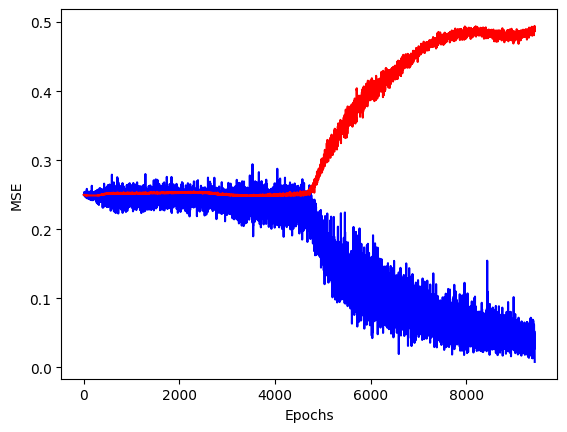

Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Promedio de métricas para el modelo con batch=50: 
{'accuracy': 0.9334146341463414, 'precision': 0.9528351675563325, 'recall': 0.9046153846153848}
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained


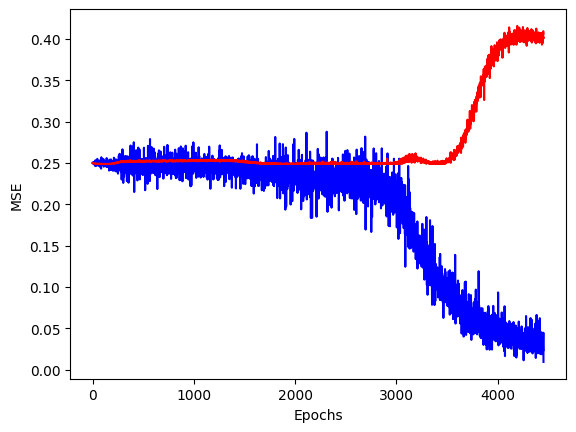

Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Promedio de métricas para el modelo con batch=100: 
{'accuracy': 0.9682926829268294, 'precision': 0.9759932057090012, 'recall': 0.9569230769230769}
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained


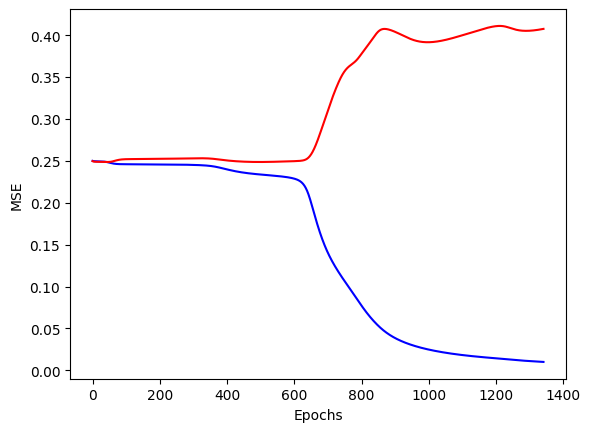

Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Size: 2
Pesos: [(11, 12), (13, 1)]
Trained
Promedio de métricas para el modelo con batch=total: 
{'accuracy': 0.9870731707317072, 'precision': 0.9877432441437698, 'recall': 0.9851282051282052}


In [ ]:
#Test de batches para el mejor modelo (obtenido previamente)
modelo_batch_1 = MLP( [12,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_1.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 50, epochs = 3000, validation = (X_val, z_val), beta = 0, verbose = False)

plt.plot(modelo_batch_1.total_error, color='blue', label='train')
plt.plot(modelo_batch_1.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()

_, _, _, metrics = cross_val(normalized_X ,Z, [12,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 50, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo con batch=50: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

###
modelo_batch_2 = MLP( [12,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_2.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 100, epochs = 3000, validation = (X_val, z_val), beta = 0, verbose = False)

plt.plot(modelo_batch_2.total_error, color='blue', label='train')
plt.plot(modelo_batch_2.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()

_, _, _, metrics = cross_val(normalized_X ,Z, [12,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 100, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo con batch=100: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })
###
modelo_batch_3 = MLP( [12,1] , X_train.shape, ["tanh",'logit'])

modelo_batch_3.train(X_train, z_train, error = 0.01, lr = 0.01 , batch_size= 500, epochs = 3000, validation = (X_val, z_val), beta = 0, verbose = False)

plt.plot(modelo_batch_3.total_error, color='blue', label='train')
plt.plot(modelo_batch_3.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()
_, _, _, metrics = cross_val(normalized_X ,Z, [12,1], ["tanh",'logit'], NSets = 10, error = 0.01, lr = 0.01 , batch_size = 500, epochs = 3000, beta = 0, verbose = False)
print(f"Promedio de métricas para el modelo con batch=total: ")
print({ key: sum(values) / len(values) for key, values in metrics.items() })

Con un threshold de 0.5, el mejor modelo es el que utilza batches totales.

Para determinar si la cantidad de epochs y el error están bien definidos, decidimos graficar como aumenta el "accuracy" del modelo a lo largo de las epochs de entrenamiento. Podemos ver que el modelo alcanza una accuracy alta tanto en train como en validación.

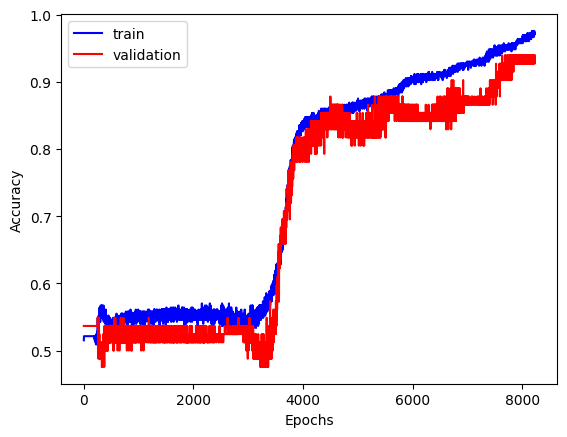

In [ ]:
def accuracy(y_pred,Z):
    y_pred_class = np.where(y_pred >= 0.5, 1, 0)
    true_positives = np.sum((y_pred_class == 1) & (Z == 1))
    true_negatives = np.sum((y_pred_class == 0) & (Z == 0))
    return (true_positives + true_negatives) / len(Z)

train_acc = []
test_acc = []
for y_train in modelo_batch_1.history_pred["train_list"]:
    train_acc.append(accuracy(y_train, z_train))

for y_val in modelo_batch_1.history_pred["val_list"]:
    test_acc.append(accuracy(y_val, z_val))

plt.plot(train_acc, color='blue', label='train')
plt.plot(test_acc, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

_________________________

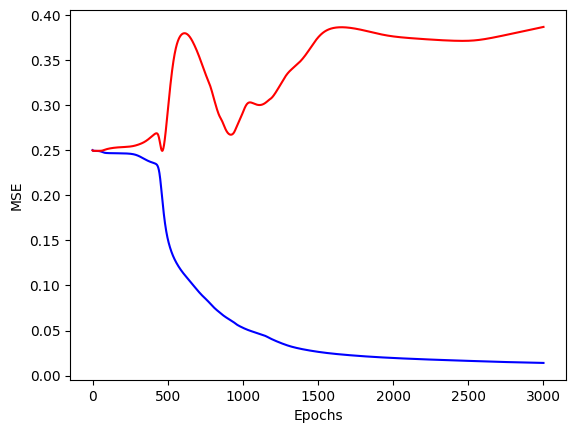

In [ ]:
#MEJOR MODELO
mejor_modelo = MLP( [12,1] , normalized_X.shape, ["tanh",'logit'])

mejor_modelo.train(normalized_X, Z, error = 0.01, lr = 0.01 , batch_size= 500, epochs = 3000, validation = (normalized_X, Z), beta = 0, verbose = False)

plt.plot(mejor_modelo.total_error, color='blue', label='train')
plt.plot(mejor_modelo.validation_error, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.close()

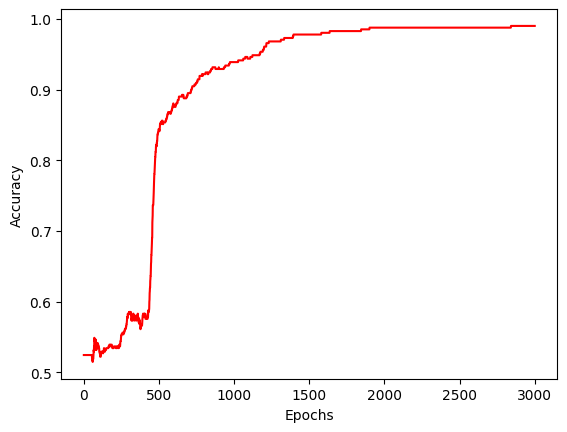

In [ ]:
def accuracy(y_pred,Z):
    y_pred_class = np.where(y_pred >= 0.5, 1, 0)
    true_positives = np.sum((y_pred_class == 1) & (Z == 1))
    true_negatives = np.sum((y_pred_class == 0) & (Z == 0))
    return (true_positives + true_negatives) / len(Z)

len(mejor_modelo.history_pred["train_list"])
train_acc = []
for y_train in mejor_modelo.history_pred["train_list"]:
    train_acc.append(accuracy(y_train, Z))

plt.plot(train_acc, color='red', label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.close()


### TESTEO DE LA MEJOR ARQUITECTURA ENCONTRADA

Finalmente nos decantamos por esta arquitectura y entrenamos la red con todos los datos. Luego de correr el notebook entero, la celda debajo permite ingresar datos de testeo y checkear la performance de la red.

In [ ]:
# INSERTAR DATOS DE TESTEO PARA CALCULAR MÉTRICAS
# Gus_X_test =
# Gus_z_test =

def calcular_metricas_para_gustavo(X,Z,modelo):
    Gus_y_predict = modelo.predict(X)
    Gus_y_pred_class = np.where(Gus_y_predict >= 0.5, 1, 0)

    true_positives = np.sum((Gus_y_pred_class == 1) & (Z == 1))
    true_negatives = np.sum((Gus_y_pred_class == 0) & (Z == 0))
    false_positives = np.sum((Gus_y_pred_class == 1) & (Z == 0))
    false_negatives = np.sum((Gus_y_pred_class == 0) & (Z == 1))

    accuracy = (true_positives + true_negatives) / len(Z)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    print("---")
    print("Threshold:", 0.5)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

# calcular_metricas_para_gustavo(Gus_X_test, Gus_z_test, mejor_modelo)